## Network regularization validation

Process for generating data from a log-linear (logistic regression) model:

* Sample features $x_{ij} \sim \mathcal{N}(0, 1)$
* Sample regression coefficients $\beta_k \sim \mathcal{N}(0, 1)$ for some $k \leq j$ (that is, features $k+1, \dots, j$ will not be correlated with the labels at all)
* Calculate Bernoulli parameters: $$\pi(x_i) = \frac{1}{1 + \exp\left(-\left(\beta_0 + \sum_j \beta_j x_{ij}\right)\right)}$$
* Sample labels $y_i \sim \text{Bernoulli}(\pi(x_i))$

In [1]:
import sys; sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utilities.classify_pytorch import TorchLR
from utilities.jaccard_utilities import compute_jaccard

In [2]:
# simulation parameters
import simulate_loglinear as ll

# seed for random numbers
seed = 42; np.random.seed(seed)
n, p = 50, 50
train_fraction = 0.8 # fraction of data used to fit the model
uncorrelated_fraction = 0.8 # fraction of features which will be uncorrelated with the outcome

X, y, pis, is_correlated = ll.simulate_ll(n, p, uncorrelated_fraction,
                                          seed=seed, verbose=True, unit_coefs=True)
train_ixs = ll.split_train_test(n, train_fraction, seed=seed, verbose=True)

X_train, X_test = X[train_ixs], X[~train_ixs]
y_train, y_test = y[train_ixs], y[~train_ixs]

Number of informative features: 10
Number of uninformative features: 40
Train samples: 40, test samples: 10


In [3]:
print(is_correlated)

[ True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]


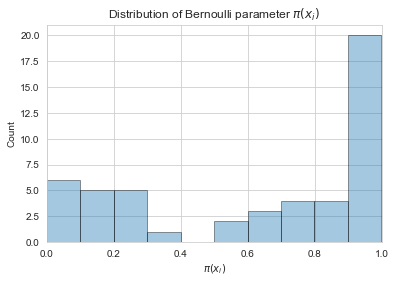

In [4]:
# plot Bernoulli parameter distribution
sns.set_style('whitegrid')
sns.distplot(pis, hist_kws={'edgecolor': 'black'}, kde=False, bins=10)
plt.xlim(0.0, 1.0)
plt.xlabel('$\pi(x_i)$')
plt.ylabel('Count')
plt.title('Distribution of Bernoulli parameter $\pi(x_i)$')
plt.show()

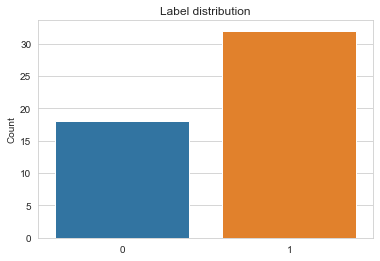

In [5]:
# plot label distribution
sns.countplot(y)
plt.ylabel('Count')
plt.title('Label distribution')
plt.show()

Now, let's test how well logistic regression can predict the outcome.

In [6]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=seed, penalty='none', solver='lbfgs')
clf.fit(X_train, y_train)
print('Sklearn train accuracy: {:.3f}'.format(clf.score(X_train, y_train)))
print('Sklearn test accuracy: {:.3f}'.format(clf.score(X_test, y_test)))

Sklearn train accuracy: 1.000
Sklearn test accuracy: 0.600


In [7]:
params_map = {
    'learning_rate': [1e-2],
    'batch_size': [50],
    'num_epochs': [200],
    'l1_penalty': [0.0]
}

torch_model = TorchLR(params_map, seed=2)
losses, preds, preds_bn = torch_model.train_torch_model(X_train, X_test, y_train, y_test, save_weights=True)
y_pred_train, y_pred_test = preds_bn
print('Torch train accuracy: {:.3f}'.format(TorchLR.calculate_accuracy(y_train, y_pred_train.flatten())))
print('Torch test accuracy: {:.3f}'.format(TorchLR.calculate_accuracy(y_test, y_pred_test.flatten())))

Torch train accuracy: 1.000
Torch test accuracy: 0.300


In [13]:
print(is_correlated)
print(torch_model.last_weights)
print(sum(abs(torch_model.last_weights.flatten())[is_correlated]))
print(sum(abs(torch_model.last_weights.flatten())[~is_correlated]))

[ True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[[-0.20162748  0.2072574   0.26279122  0.22494411  0.29318982  0.02876436
   0.19967467  0.12137789  0.27721617  0.10219419 -0.19708218  0.05214804
  -0.21608119  0.29561514  0.24808563 -0.1553258   0.2549955  -0.30630493
  -0.1167611  -0.12542874 -0.26078528  0.2236698  -0.23967868 -0.14239761
  -0.15694077 -0.1017276   0.21840782 -0.01302954  0.12538609  0.15449639
  -0.3555757   0.12323473  0.2835278  -0.12909916 -0.19301759 -0.1395767
  -0.02273916 -0.10569194  0.11697028 -0.1741698  -0.14394286  0.12247694
   0.28935078  0.22630176  0.13727875 -0.15744558 -0.15422137 -0.11431066
   0.16028263  0.23988983]]
1.9190373085439205
6.993451830931008


In [9]:
# testing if the network will help
import itertools as it

p_uncorr = int(uncorrelated_fraction * p)
p_corr = p - p_uncorr

corr_net = np.zeros((p_corr, p_corr))
for (i, j) in it.combinations(range(p_corr), 2):
    corr_net[i, j] = 1
    corr_net[j, i] = 1
adj_matrix = np.block([
    [corr_net, np.zeros((p_corr, p_uncorr))],
    [np.zeros((p_uncorr, p_corr)), np.eye(p_uncorr)]
])
nodelist = np.arange(p_uncorr+p_corr)

adj_matrix[:10, :10]

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]])

In [10]:
import os
import networkx as nx

def save_numpy_to_el(adj, nodelist, filename):
    G = nx.from_numpy_matrix(adj)
    G = nx.relabel_nodes(G, {ix: n for ix, n in enumerate(nodelist)})
    nx.write_weighted_edgelist(G, filename, delimiter='\t')
    
networks_dir = './sim_networks'

if not os.path.exists(networks_dir):
    os.makedirs(networks_dir)
    
network_file = os.path.join(networks_dir, 'sim_p{}_uncorr{}.tsv'.format(
                                p, uncorrelated_fraction))
save_numpy_to_el(adj_matrix, nodelist, network_file)

In [14]:
params_map = {
    'learning_rate': [1e-2],
    'batch_size': [50],
    'num_epochs': [200],
    'l1_penalty': [0.0],
    'network_penalty': [1]
}

torch_model = TorchLR(params_map, seed=2, network_file=network_file,
                      network_features=np.array([1 for _ in range(p)]).astype('bool'),
                      correlated_features=is_correlated,
                      sim_network_size=p)
losses, preds, preds_bn = torch_model.train_torch_model(X_train, X_test, y_train, y_test, save_weights=True)
y_pred_train, y_pred_test = preds_bn
print('Torch train accuracy: {:.3f}'.format(TorchLR.calculate_accuracy(y_train, y_pred_train.flatten())))
print('Torch test accuracy: {:.3f}'.format(TorchLR.calculate_accuracy(y_test, y_pred_test.flatten())))

Torch train accuracy: 0.900
Torch test accuracy: 0.400


In [15]:
print(is_correlated)
print(torch_model.last_weights)
print(sum(abs(torch_model.last_weights.flatten())[is_correlated]))
print(sum(abs(torch_model.last_weights.flatten())[~is_correlated]))

[ True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[[-0.09057994  0.09077875  0.15957867  0.1153088   0.18325034 -0.02130732
   0.10403572  0.00952064  0.15753424 -0.00368207 -0.10083873  0.0922138
  -0.14413401  0.24258682  0.13313794 -0.06184516  0.17735668 -0.20534511
  -0.13676906  0.00708095 -0.24034938  0.11434186 -0.13327605 -0.02391467
  -0.12302092 -0.05460696  0.11443742  0.01425993  0.03870448  0.05297938
  -0.25175956  0.02782171  0.16053541 -0.02717556 -0.09910819 -0.16314127
   0.03674512 -0.00249196  0.07740044 -0.17481087 -0.13896967 -0.00225437
   0.1826824   0.16877173  0.03412782 -0.05312227 -0.06005002 -0.10003265
   0.03612278  0.1342574 ]]
0.9355764838401228
4.142580513609573


## Experiments

We want to look at:

* Accuracy: How well can we predict the outcome from the features?
* Feature selection: How well can we predict which features are uncorrelated with the outcome?

In these experiments, we record the above for varying dataset shapes (tall, square-ish, wide) and varying numbers of features that are uncorrelated with the outcome.

In [ ]:
# one tall dataset (n > p), one square dataset (n = p), one wide dataset (n < p)
dataset_sizes = {
    'tall': (1000, 20), 
    'square': (1000, 1000),
    'wide': (1000, 10000)
}
uncorr_fracs = [0.0, 0.2, 0.5, 0.8]

# just keep this constant for now, 0.8/0.2 train/test split
train_frac = 0.8

results = []

for seed in range(5):
    for ds, (n, p) in dataset_sizes.items():
        for uncorr_frac in uncorr_fracs:
        
            # generate data with given parameters
            X, y, _, is_correlated = ll.simulate_ll(n, p, uncorr_frac, seed=seed)
            train_ixs = ll.split_train_test(n, train_frac, seed=seed)
            X_train, X_test = X[train_ixs], X[~train_ixs]
            y_train, y_test = y[train_ixs], y[~train_ixs]

            # fit sklearn classifier
            clf = LogisticRegression(random_state=seed, penalty='l1', solver='liblinear')
            clf.fit(X_train, y_train)
            sk_train_acc = clf.score(X_train, y_train)
            sk_test_acc = clf.score(X_test, y_test)

            # fit torch classifier
            torch_model = TorchLR(params_map, seed=seed)        
            _, __, preds_bn = torch_model.train_torch_model(X_train, X_test, y_train, y_test,
                                                            save_weights=True)
            torch_train_acc = TorchLR.calculate_accuracy(y_train, preds_bn[0].flatten())
            torch_test_acc = TorchLR.calculate_accuracy(y_test, preds_bn[1].flatten())
            
            # random prediction baseline
            random_preds_train = (np.random.uniform(size=len(y_train)) > 0.5).astype('int')
            random_preds_test = (np.random.uniform(size=len(y_test)) > 0.5).astype('int')
            random_train_acc = TorchLR.calculate_accuracy(y_train, random_preds_train)
            random_test_acc = TorchLR.calculate_accuracy(y_test, random_preds_test)

            # calculate coefficient overlap
            torch_coefs = torch_model.last_weights.flatten()
            close_to_zero = (np.abs(torch_coefs) < (np.abs(torch_coefs).max() / 1000))
            torch_coefs[close_to_zero] = 0
            
            # select random coefficients to zero out as a baseline
            # just select the same number of zeros as the torch coefficients for now
            random_coefs = np.ones(torch_coefs.shape)
            random_coefs[:np.count_nonzero(torch_coefs == 0)] = 0
            np.random.shuffle(random_coefs)
            
            sk_jaccard = compute_jaccard(np.where(~is_correlated)[0], np.where(clf.coef_.flatten() == 0)[0])
            torch_jaccard = compute_jaccard(np.where(~is_correlated)[0], np.where(torch_coefs == 0)[0])
            random_jaccard = compute_jaccard(np.where(~is_correlated)[0], np.where(random_coefs == 0)[0])

            results.append([seed, ds, uncorr_frac, 'sklearn', sk_train_acc, sk_test_acc, sk_jaccard[0]])
            results.append([seed, ds, uncorr_frac, 'torch', torch_train_acc, torch_test_acc, torch_jaccard[0]])
            results.append([seed, ds, uncorr_frac, 'random', random_train_acc, random_test_acc, random_jaccard[0]])
        
results_df = pd.DataFrame(results, columns=['seed', 'dataset', 'uncorr_frac', 'imp', 'train_acc', 'test_acc', 'coef_sim'])
results_df.head()

In [ ]:
tall_df = results_df[results_df['dataset'] == 'tall']
tall_df.head(n=20)

In [ ]:
sns.set(style='whitegrid', rc={'figure.figsize': (15, 8)})
fig, axarr = plt.subplots(2, 3)
for ix, (dataset, (n, p)) in enumerate(dataset_sizes.items()):
    ax1 = axarr[0, ix]
    data_df = results_df[results_df['dataset'] == dataset]
    sns.set_style('whitegrid')
    sns.lineplot(data=data_df, x='uncorr_frac', y='train_acc', err_style='bars', style='imp', hue='imp', ax=ax1)
    ax1.set_xlabel('Fraction of uncorrelated features')
    ax1.set_ylim(0.45, 1.05)
    if ix == 0:
        ax1.set_ylabel('Predictive accuracy on training data')
    else:
        ax1.set_ylabel('')
    ax1.set_title('{} dataset (dimensions: n={}, p={})'.format(dataset, n, p))
    ax2 = axarr[1, ix]
    data_df = results_df[results_df['dataset'] == dataset]
    sns.set_style('whitegrid')
    sns.lineplot(data=data_df, x='uncorr_frac', y='test_acc', err_style='bars', style='imp', hue='imp', ax=ax2)
    ax2.set_xlabel('Fraction of uncorrelated features')
    ax2.set_ylim(0.45, 1.05)
    if ix == 0:
        ax2.set_ylabel('Predictive accuracy on test data')
    else:
        ax2.set_ylabel('')
    ax2.set_title('{} dataset (dimensions: n={}, p={})'.format(dataset, n, p))
plt.tight_layout()
fig.suptitle('Accuracy vs. number of uncorrelated features on log-linear simulated data')
fig.subplots_adjust(top=0.91)
plt.show()